In [1]:
fname = "334_61"
sigma = 4.5

%matplotlib notebook

import pandas as pd
import numpy as np

import matplotlib
import seaborn
import matplotlib.dates as md
from matplotlib import pyplot as plt

In [2]:
df = pd.read_csv("./input/clean_"+fname+".csv")
#df.drop(["meter_id"],axis=1,inplace=True)
print(df.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 75118 entries, 0 to 75117
Data columns (total 3 columns):
meter_id     75118 non-null object
Timestamp    75118 non-null object
Values       75118 non-null float64
dtypes: float64(1), object(2)
memory usage: 1.7+ MB
None


<IPython.core.display.Javascript object>


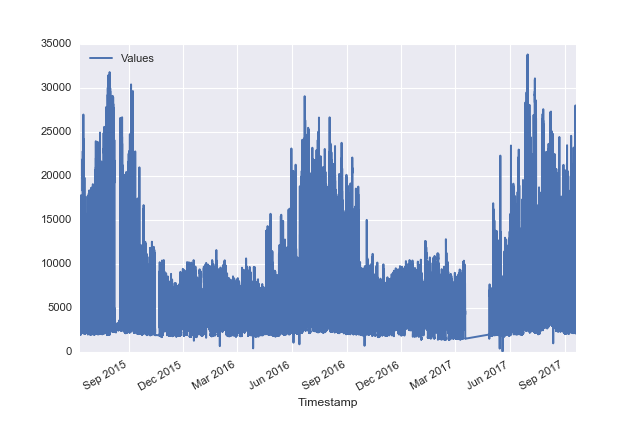

In [3]:
df['Timestamp'] = pd.to_datetime(df['Timestamp'])
df.plot(x='Timestamp', y='Values')

In [4]:
df['seconds'] = df['Timestamp'].dt.second
df['minutes'] = df['Timestamp'].dt.minute 
df['hours'] = df['Timestamp'].dt.hour
df['mins'] = df['hours'].map(str)+" "+df['minutes'].map(str)
df['years'] = df['Timestamp'].dt.year
df['days'] = df['Timestamp'].dt.day
df['months'] = df['Timestamp'].dt.month
df['day'] = df['years'].map(str)+" "+df['months'].map(str)+" "+df['days'].map(str)
df['DayOfTheWeek'] = df['Timestamp'].dt.dayofweek
df['WeekDay'] = (df['DayOfTheWeek'] < 5).astype(int)
df['daylight'] = ((df['hours'] >= 8) & (df['hours'] <= 20)).astype(int)
df['time_epoch'] = (df['Timestamp'].astype(np.int64)/100000000000).astype(np.int64)
df['diff'] = df.Values.diff()

In [5]:
df.head()

,meter_id,Timestamp,Values,seconds,minutes,hours,mins,years,days,months,day,DayOfTheWeek,WeekDay,daylight,time_epoch,diff
0,334_61,2015-06-11 00:00:00,2035.0,0,0,0,0 0,2015,11,6,2015 6 11,3,1,0,14339808,NaN
1,334_61,2015-06-11 00:15:00,2074.0,0,15,0,0 15,2015,11,6,2015 6 11,3,1,0,14339817,39.0
2,334_61,2015-06-11 00:30:00,2062.0,0,30,0,0 30,2015,11,6,2015 6 11,3,1,0,14339826,-12.0
3,334_61,2015-06-11 00:45:00,2025.0,0,45,0,0 45,2015,11,6,2015 6 11,3,1,0,14339835,-37.0
4,334_61,2015-06-11 01:00:00,2034.0,0,0,1,1 0,2015,11,6,2015 6 11,3,1,0,14339844,9.0


In [6]:
cols =  ["months","WeekDay","hours"]

ds = df[(df["years"]!=2013)&(df["years"]!=2018)]
dm = dict(ds.groupby(by=cols)["Values"].mean())
dv = dict(ds.groupby(by=cols)["Values"].std())
dc = dict(ds.groupby(by=cols)["Values"].count())
df["key"] = list(zip(df[cols[0]], df[cols[1]], df[cols[2]]))

s = []
c = []
for x in dm:
    try:
        t = dm[x]/dv[x]
        s.append(t)
        c.append(dc[x])
    except:
        print(x,dm[x],dv[x],dm[x]/dv[x])
        
np.min(s),np.median(s),np.mean(s),np.max(s),np.median(c)

(1.4045401991996913,
 5.4876376813971195,
 6.2953846208283757,
 21.807098811503852,
 108.0)

In [7]:
from tqdm import tqdm
a = []
for key, value in zip(df.key, df.Values):
    try:
        a.append(int(abs(dm[key]-value)>sigma*dv[key]))
    except:
        a.append(0)
        #print(key)
df['anomaly21'] = a
print(sum(a),sum(a)/len(df))

64 0.0008519928645597593


<IPython.core.display.Javascript object>


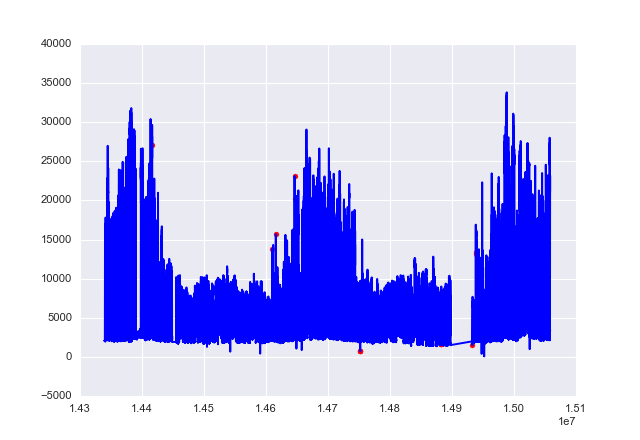

In [8]:
# visualisation of anomaly throughout time (viz 1)
fig, ax = plt.subplots()

a = df.loc[df['anomaly21'] == 1, ['time_epoch', 'Values']] #anomaly

ax.plot(df['time_epoch'], df['Values'], color='blue')
ax.scatter(a['time_epoch'],a['Values'], color='red')
plt.show()

<IPython.core.display.Javascript object>


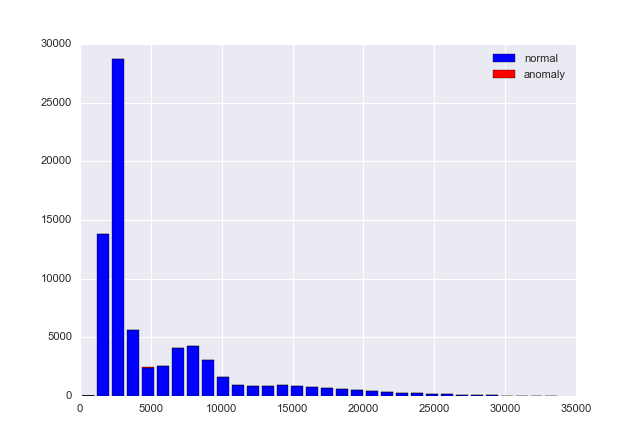

In [9]:
# visualisation of anomaly with temperature repartition (viz 2)
a = df.loc[df['anomaly21'] == 0, 'Values']
b = df.loc[df['anomaly21'] == 1, 'Values']

fig, axs = plt.subplots()
axs.hist([a,b], bins=32, stacked=True, color=['blue', 'red'], label=['normal', 'anomaly'])
plt.legend()
plt.show()

In [10]:
df.to_csv("./output/"+fname+".csv", columns=["meter_id","Timestamp","anomaly21", "Values"], index=False)